# **Building an Image Similarity System with 🤗 Transformers**


In this notebook, you'll learn to build an image similarity system with 🤗 Transformers. Finding out the similarity between a query image and potential candidates is an important use case for information retrieval systems, reverse image search, for example. All the system is trying to answer is that, given a _query_ image and a set of _candidate_ images, which images are the most similar to the query image. 

## 🤗 Datasets library

This notebook leverages the [`datasets` library](https://huggingface.co/docs/datasets/) as it seamlessly supports parallel processing which will come in handy when building this system. 


## Any model and dataset

Although the notebook uses a ViT-based model ([`nateraw/vit-base-beans`](https://huggingface.co/nateraw/vit-base-beans)) and a particular dataset ([Beans](https://huggingface.co/datasets/beans)), it can be easily extended to use other models supporting vision modality and other image datasets. Some notable models, you could try:

* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin)
* [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext)
* [RegNet](https://huggingface.co/docs/transformers/model_doc/regnet)

The approach presented in the notebook can potentially be extended to other modalities as well.

---

Before we start, let's install the `datasets` and `transformers` libraries.


In [1]:
!pip install transformers datasets -q 

     |████████████████████████████████| 5.8 MB 4.2 MB/s 
     |████████████████████████████████| 451 kB 62.5 MB/s 
     |████████████████████████████████| 182 kB 85.2 MB/s 
     |████████████████████████████████| 7.6 MB 82.1 MB/s 
     |████████████████████████████████| 212 kB 90.3 MB/s 
     |████████████████████████████████| 132 kB 93.6 MB/s 
     |████████████████████████████████| 127 kB 89.5 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

## Building an image similarity system 

To build this system, we first need to define how we want to compute the similarity between two images. One widely popular practice is to compute dense representations (embeddings) of the given images and then use the [cosine similarity metric](https://en.wikipedia.org/wiki/Cosine_similarity) to determine how similar the two images are. 

For this tutorial, we'll be using “embeddings” to represent images in vector space. This gives us a nice way to meaningfully compress the high-dimensional pixel space of images (224 x 224 x 3, for example) to something much lower dimensional (768, for example). The primary advantage of doing this is the reduced computation time in the subsequent steps.

![](https://i.ibb.co/mTtdh7F/embeddings.png)

Don't worry if these things do not make sense at all. We will discuss these things in more detail shortly. 

### Loading a base model to compute embeddings

"Embeddings" encode the semantic information of images. To compute the embeddings from the images, we'll use a vision model that has some understanding of how to represent the input images in the vector space.  This type of models is also commonly referred to as image encoders.

For loading the model, we leverage the [`AutoModel` class](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModel). It provides an interface for us to load any compatible model checkpoint from the Hugging Face Hub. Alongside the model, we also load the processor associated with the model for data preprocessing. 

In [2]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/756 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In this case, the checkpoint was obtained by fine-tuning a [Vision Transformer based model](https://huggingface.co/google/vit-base-patch16-224-in21k) on the [`beans` dataset](https://huggingface.co/datasets/beans). To learn more about the model, just click the model link and check out its model card.

The warning is telling us that the underlying model didn't use anything from the `classifier`. _Why did we not use `AutoModelForImageClassification`?_

This is because we want to obtain dense representations of the images and not discrete categories, which are what `AutoModelForImageClassification` would have provided. 

Then comes another question - _why this checkpoint in particular?_

We're using a specific dataset to build the system as mentioned earlier. So, instead of using a generalist model (like the [ones trained on the ImageNet-1k dataset](https://huggingface.co/models?dataset=dataset:imagenet-1k&sort=downloads), for example), it's better to use a model that has been fine-tuned on the dataset being used. That way, the underlying model has a better understanding of the input images. 

Now that we have a model for computing the embeddings, we need some candidate images to query against. 

### Loading the dataset for candidate images

 
To find out similar images, we need a set of candidate images to query against. We'll use the `train` split of the [`beans` dataset](https://huggingface.co/datasets/beans) for that purpose. To know more about the dataset, just follow the link and explore its dataset card.

In [3]:
from datasets import load_dataset

dataset = load_dataset("beans")

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

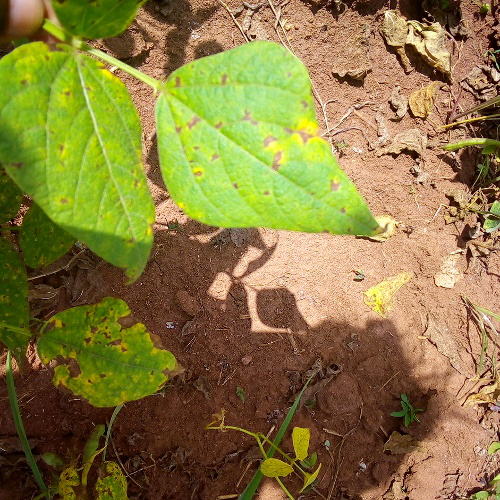

In [4]:
# Check a sample image.
dataset["train"][0]["image"]

The dataset has got three columns / features:

In [5]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

Next, we set up two dictionaries for our upcoming utilities:

* `label2id` which maps the class labels to integers.
* `id2label` doing the opposite of `label2id`.

In [6]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

With these components, we can proceed to building our image similarity system. For demonstrating this, we'll use 100 samples from the candidate image dataset so that the overall runtime is short. 

In [7]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

Below, you can find a pictorial overview of the process underlying fetching similar images. 

<div align="center">
<img src="https://i.ibb.co/rm2FWwf/fetch-similar-process.png" width=675/>
</div>

Breaking down the above figure a bit, we have:

1. Extract the embeddings from the candidate images (`candidate_subset`) storing them in a matrix.
2. Take a query image and extract its embeddings. 
3. Iterate over the embedding matrix (computed in step 1) and compute similarity score in between the query embedding and the current candidate embeddings. We usually maintain a dictionary-like mapping  maintaining a correspondence between some identifier of the candidate image and the similarity scores. 
4. Sort the mapping structure w.r.t the similarity scores and return the identifiers underlying. We use these identifiers to fetch the candidate samples.

In the next cells, we implement the above procedure in code. 

In [8]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [9]:
import torch


def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


# Here, we map embedding extraction utility on our candidate image dataset.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

  0%|          | 0/5 [00:00<?, ?ba/s]

Next, for convenience, we create a dictionary mapping the identifiers of the candidate images and their embeddings we just computed. 

In [10]:
from tqdm.auto import tqdm


id_embeddings = {}

for id in tqdm(range(len(candidate_subset_emb))):
    embeddings, label = (
        candidate_subset_emb[id]["embeddings"],
        candidate_subset_emb[id]["labels"],
    )

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    id_embeddings.update({entry: embeddings})

  0%|          | 0/100 [00:00<?, ?it/s]

We'll use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to compute the similarity score in between two embedding vectors. We'll then use it to fetch similar candidate samples given a query sample. 

In [11]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    similarity = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return float(similarity)


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    similarity_mapping = {}

    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    for id_entry in id_embeddings:
        candidate_embeddings = torch.tensor(id_embeddings[id_entry]).unsqueeze(0)
        sim_score = compute_scores(candidate_embeddings, query_embeddings)
        similarity_mapping.update({id_entry: sim_score})

    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

Now, we can put these utilities to test. 

In [12]:
import numpy as np


test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 2
Top 5 candidate labels: [2, 2, 2, 2, 2]


We can notice that given the query image, candidate images having similar labels were fetched. 

Now, we can visualize all this. 

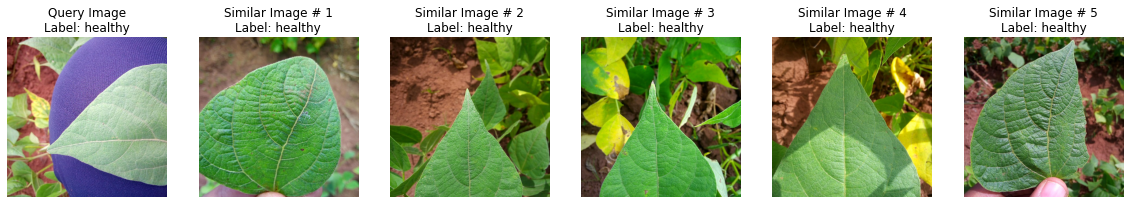

In [13]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

We now have a working image similarity system. But in reality, you'll be dealing with a lot more candidate images. Taking that into consideration, our current procedure has got multiple drawbacks:

* If we store the embeddings as is then the memory requirements can shot up pretty quickly especially when dealing with millions of candidate images. The embeddings are 768-d in our case, which can be still quite high in the large-scale regime. 
* Having high-dimensional embeddings have a direct effect on the subsequent computations involved in the retrieval part. 

So, if we can somehow reduce the dimensionality of the embeddings without disturbing their meaning, we can still maintain a good trade-off between speed and retrieval quality. 

So, in the next sections, we'll implement the _hashing_ utilities to optimize the runtime of our image similarity system. 

### Random projection and locality-sensitive hashing (LSH)

We can choose to just compute the embeddings with our base model and then apply a similarity metric for the system. But in realistic settings, the embeddings are still high dimensional (in this case `(768, )`). This eats up storage and also increases the query time. 

To mitigate that effect, we'll implement the following things:

* First, we reduce the dimensionality of the embeddings with [random projection](https://cs-people.bu.edu/evimaria/cs565/kdd-rp.pdf). The main idea is that if the distance between a group of vectors can roughly be preserved on a plane, the dimensionality of the plane can be further reduced. 
* We then compute the bitwise hash values of the projected vectors to determine their hash buckets. Similar images will likely be closer in the embedding space. Therefore, they will likely also have the same hash values and are likely to go into the same hash bucket. From a deployment perspective, bitwise hash values are cheaper to store and operate on. If you're unfamiliar with the relevant concepts of hashing, then [this resource](https://computersciencewiki.org/index.php/Hashing.) could be helpful. 

In [14]:
import numpy as np


seed = 2022
hash_size = 8
np.random.seed(seed)


# Define random vectors to project with.
random_vectors = np.random.randn(hash_size, hidden_dim).T


def hash_func(embedding, random_vectors=random_vectors):
    """Randomly projects the embeddings and then computes bit-wise hashes."""
    if not isinstance(embedding, np.ndarray):
        embedding = np.array(embedding)
    if len(embedding.shape) < 2:
        embedding = np.expand_dims(embedding, 0)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

Next, we define a utility that can be mapped to our dataset for computing hashes of the training images in a parallel manner. 

In [15]:
from typing import Union


def compute_hash(model: Union[torch.nn.Module, str]):
    """Computes hash on a given dataset."""
    device = model.device

    def pp(example_batch):
        # Prepare the input images for the model.
        image_batch = example_batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in image_batch]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}

        # Compute embeddings and pool them i.e., take the representations from the [CLS]
        # token.
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu().numpy()

        # Compute hashes for the batch of images.
        hashes = [hash_func(embeddings[i]) for i in range(len(embeddings))]
        example_batch["hashes"] = hashes
        return example_batch

    return pp

Next, we build three utility classes building our hash tables:

* `Table`
* `LSH`
* `BuildLSHTable` 

Collectively, these classes implement Locality Sensitive Hashing (the idea locally close points share the same hashes). 

**Disclaimer**: Some code has been used from [this resource](https://keras.io/examples/vision/near_dup_search/) for writing these classes. 

### The `Table` class

The `Table` class has two methods:

* `add()` lets us build a dictionary mapping the hashes of the candidate images to their identifiers. 
* `query()` lets us take as inputs the query hashes and check if they exist in the table.

The table built in this class is referred to as a hash bucket. 

In [16]:
from typing import List


class Table:
    def __init__(self, hash_size: int):
        self.table = {}
        self.hash_size = hash_size

    def add(self, id: int, hashes: List[int], label: int):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, hashes: List[int]):
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

### The `LSH` class 

Our dimensionality reduction technique involves a degree of randomness. This can lead to a situation where similar images may not get mapped to the same hash bucket every time the process is run. To reduce this effect, we'll maintain multiple hash tables. The number of hash tables and the reduction dimensionality are the two key hyperparameters here. 

In [17]:
class LSH:
    def __init__(self, hash_size, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size))

    def add(self, id: int, hash: List[int], label: int):
        for table in self.tables:
            table.add(id, hash, label)

    def query(self, hashes: List[int]):
        results = []
        for table in self.tables:
            results.extend(table.query(hashes))
        return results

### The `BuildLSHTable` class

It lets us:

* `build()`: build the hash tables. 
* `query()` with an input image aka the query image. 

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
from tqdm.auto import tqdm
from PIL import Image
import datasets


class BuildLSHTable:
    def __init__(
        self,
        model: Union[torch.nn.Module, str],
        batch_size: int = 48,
        hash_size: int = hash_size,
        dim: int = hidden_dim,
        num_tables: int = 10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.num_tables)

        self.batch_size = batch_size
        self.model = model
        self.hash_fn = compute_hash(
            self.model.to(device)
            if isinstance(self.model, torch.nn.Module)
            else self.model
        )

    def build(self, ds: datasets.DatasetDict):
        dataset_hashed = ds.map(self.hash_fn, batched=True, batch_size=self.batch_size)

        for id in tqdm(range(len(dataset_hashed))):
            hash, label = dataset_hashed[id]["hashes"], dataset_hashed[id]["labels"]
            self.lsh.add(id, hash, label)

    def query(self, image, verbose=True):
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Compute the hashes of the query image and fetch the results.
        example_batch = dict(image=[image])
        hashes = self.hash_fn(example_batch)["hashes"][0]

        results = self.lsh.query(hashes)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = {}
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts

**Notes on quantifying similarity**:

We're using [Jaccard index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) to quantify the similarity between the query image and the candidate images. As per [Scikit Learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html):

> it is defined as the size of the intersection divided by the size of the union of two label sets.

Since we're using LSH to build the similarity system and the hashes are effectively sets, Jaccard index is a good metric to use here. 


### Building the LSH tables

In [20]:
lsh_builder = BuildLSHTable(model)
lsh_builder.build(dataset["train"])

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/1034 [00:00<?, ?it/s]

To get a better a idea of how the tables are represented internally within `lsh_builder`, let's investigate the contents of a single table.

In [21]:
idx = 0
for hash, entry in lsh_builder.lsh.tables[0].table.items():
    if idx == 5:
        break
    if len(entry) < 5:
        print(f"Hash: {hash}, entries: {entry}")
        idx += 1

Hash: 57, entries: [{'id_label': '16_0'}, {'id_label': '213_0'}, {'id_label': '632_1'}]
Hash: 24, entries: [{'id_label': '27_0'}]
Hash: 136, entries: [{'id_label': '31_0'}, {'id_label': '168_0'}, {'id_label': '286_0'}, {'id_label': '340_0'}]
Hash: 193, entries: [{'id_label': '45_0'}, {'id_label': '47_0'}, {'id_label': '94_0'}, {'id_label': '231_0'}]
Hash: 185, entries: [{'id_label': '63_0'}, {'id_label': '254_0'}]


We notice that for a given hash value, we have entries where labels are the same. Because of the randomness induced in the process, we may also notice some entries coming from different labels. It can happen for various reasons:

* The reduction dimensionality is too small for compression. 
* The underlying images may be visually quite similar to one another yet have different labels. 

In both of the above cases, experimentation is really the key to improving the results. 

Now that the LSH tables have been built, we can use them to query them with images. 

## Inference

In this secton, we'll take query images from the `test` split of our dataset and retrieve the similar images from the set of candidate images we have. 

In [22]:
def visualize_lsh(lsh_class: BuildLSHTable, top_k: int = 5):
    idx = np.random.choice(len(dataset["test"]))

    image = dataset["test"][idx]["image"]
    label = dataset["test"][idx]["labels"]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == top_k:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        candidates.append(dataset["train"][int(image_id)]["image"])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)

Matches: 1740
Matches: 1740
Matches: 1740
Matches: 10
Matches: 580


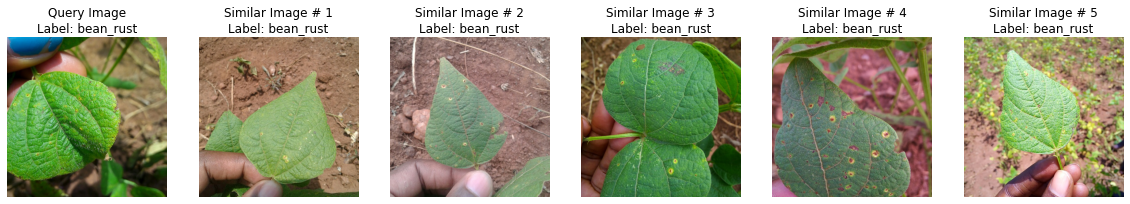

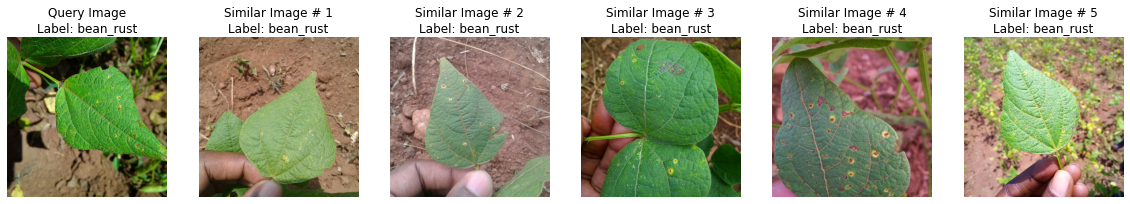

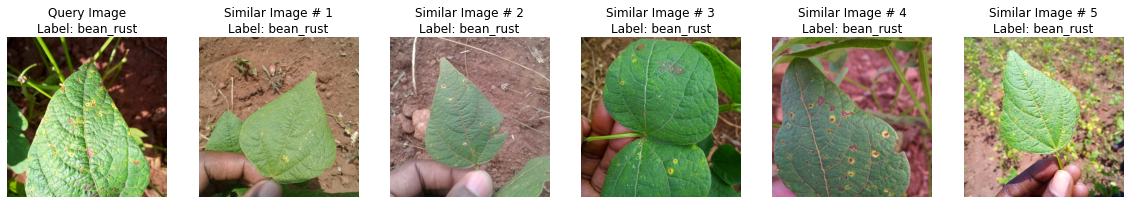

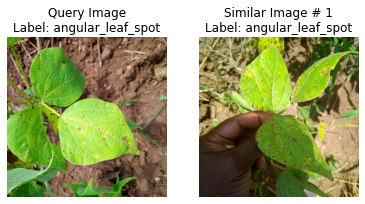

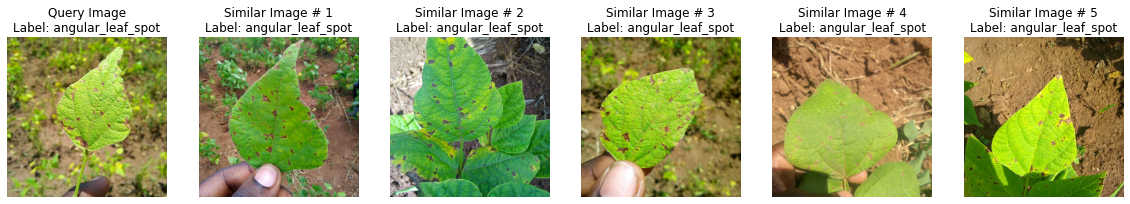

In [23]:
for _ in range(5):
    visualize_lsh(lsh_builder)

Not bad! Looks like our similarity system is fetching the correct images. 

## Conclusion

For practical purposes, we won't be building the LSH tables ourselves. There are multiple industry-grade tools that can do this (and so much more) for us:

* [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
* [Annoy](https://github.com/spotify/annoy)
* [FAISS](https://github.com/facebookresearch/faiss)
* [Vald](https://github.com/vdaas/vald)

We encourage you to try these tools out and rebuild this system. 

We used random projection for dimensionality reduction. This can also lead to information loss further leading to poorer quality in retrieval. There are other and potentially better techniques we can employ here such as [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [UMAP](https://umap-learn.readthedocs.io/). But be aware of their computational costs too. 